### Boston Housing
Boston Housing dataset

https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

Using the Boston House-price dataset available at the URL provided above, perform the following tasks using PySpark: 

1. Compute the pairwise correlations of the variables; 
2. Select the top three variables based on the pairwise correlations of the variables; 
3. Create a regression model using a polynomial function of degree two on the three selected variables. Use 70% of the data for training; 
4. Compute the R-Squared value of the model using the remaining 30% of the test data; and 


Import necessary libraries

First, let's import the necessary libraries and then load the dataset from the csv file

In [10]:
# Visualising Library
!pip install seaborn 
# pandas for data manipulation and analysis. In this code we use it to show scatter plots.
import pandas as pd 

#Seaborn is a library for making statistical graphics in Python. 
#It builds on top of matplotlib and integrates closely with pandas data structures. 
#Seaborn helps you explore and understand your data.
import seaborn as sb
# We use matplotlib for create axe and figures to plot data 
from matplotlib import pyplot as plt 
from pyspark.ml.feature import VectorAssembler 
from pyspark.sql.types import DoubleType 
from pyspark.ml.linalg import Vectors
# For use the column name of the dataframe in pyspark 
from pyspark.sql.functions import col 
from pyspark.sql import SparkSession

In [11]:
spark = SparkSession.builder. getOrCreate()

### Import the Dataset

#### Variables in order:
 
 * **CRIM**     per capita crime rate by town
 
 * **ZN**       proportion of residential land zoned for lots over 25,000 sq.ft.
 
 * **INDUS**    proportion of non-retail business acres per town
 
 * **CHAS**     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 
 * **NOX**     nitric oxides concentration (parts per 10 million)
 
 * **RM**       average number of rooms per dwelling
 
 * **AGE**      proportion of owner-occupied units built prior to 1940
 
 * **DIS**      weighted distances to five Boston employment centres
 
 * **RAD**      index of accessibility to radial highways
 
 * **TAX**      full-value property-tax rate per $10,000
 
 * **PTRATIO**  pupil-teacher ratio by town
 
 * **B**        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 
 * **LSTAT**    % lower status of the population
 
 * **MEDV**     Median value of owner-occupied homes in $1000's

In [12]:
# Here again we use infraschema becouse we need all columns to be double.
boston_housing = spark.read.option('header', 'true').csv('boston.csv', inferSchema=True)
boston_housing.show()
print (boston_housing.dtypes)

+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   CRIM|  ZN|INDUS|CHAS|  NOX|   RM|  AGE|   DIS|RAD|TAX|PTRATIO|     B|LSTAT|MEDV|
+-------+----+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575| 65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421| 78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185| 61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998| 45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147| 54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
|0.02985| 0.0| 2.18|   0|0.458| 6.43| 58.7|6.0622|  3|222|   18.7|394.12| 5.21|28.7|
|0.08829|12.5| 7.87|   0|0.524|6.012| 66.6|5.5605|  5|311|   15.2| 395.6|12.43|22.9|
|0.14455|12.5| 7.87|   0|0.524|6.172| 96.1|5.9505|  5|311|   15.2| 396.9|19.15|27.1|
|0.21124|12.5| 7.87|   0|0.524|5.631|100.0|6.0821|  5|311|   15.2

### Question 1:

Compute the pairwise correlations of the variables;

<Axes: >

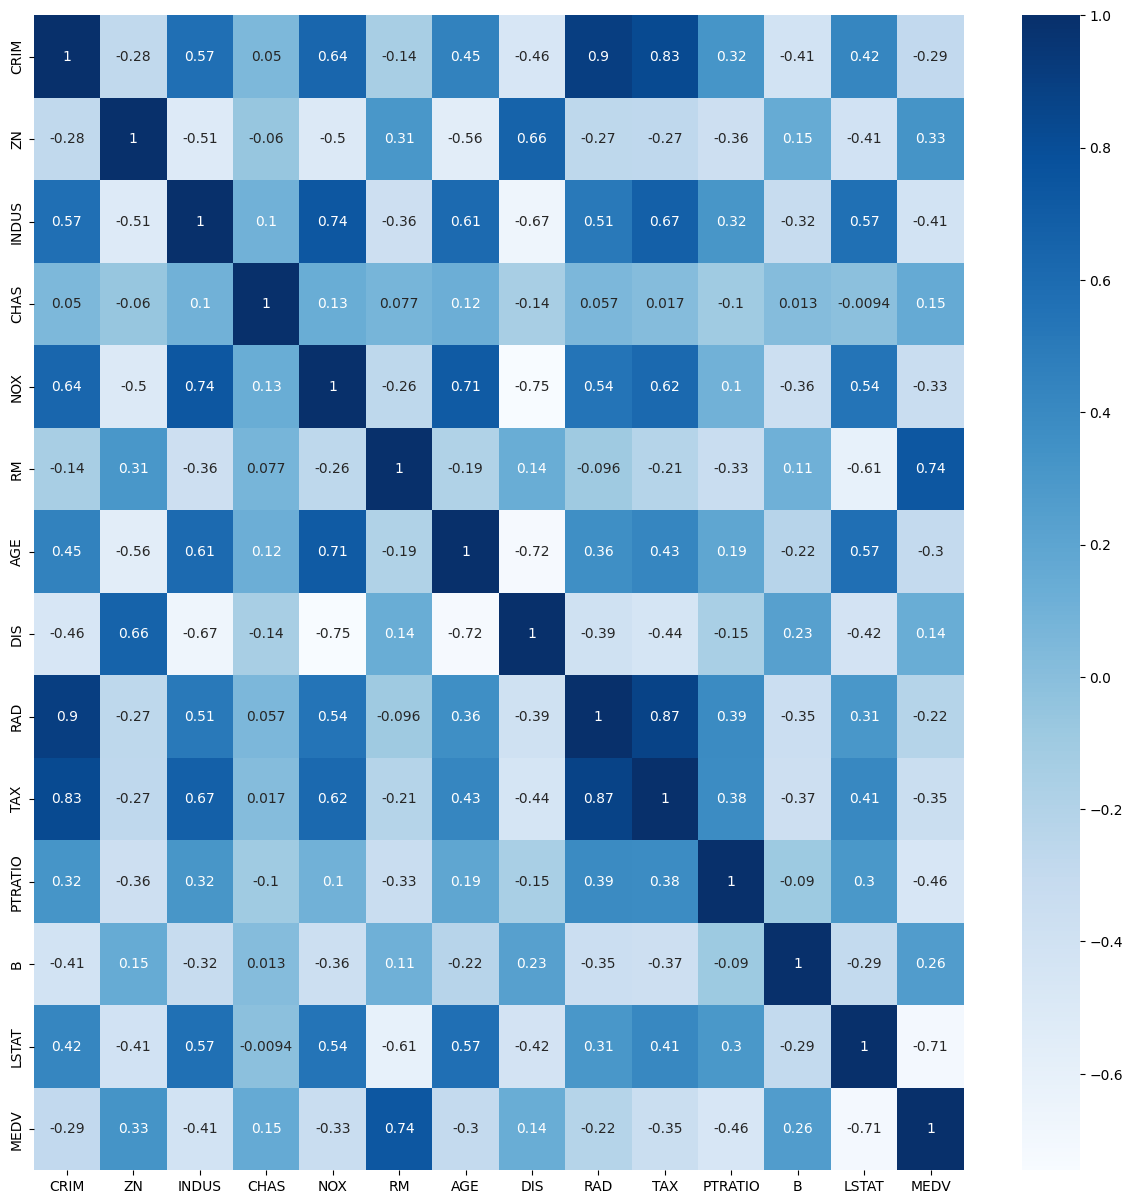

In [16]:
boston_housing_pandas_dataframe = boston_housing.toPandas ()
fig, ax = plt.subplots(figsize=(15, 15))
sb.heatmap(boston_housing_pandas_dataframe.corr(), cmap="Blues", annot=True, ax=ax)

### Question 2:  

Select the top three variables based on the pairwise correlations of the variables; 

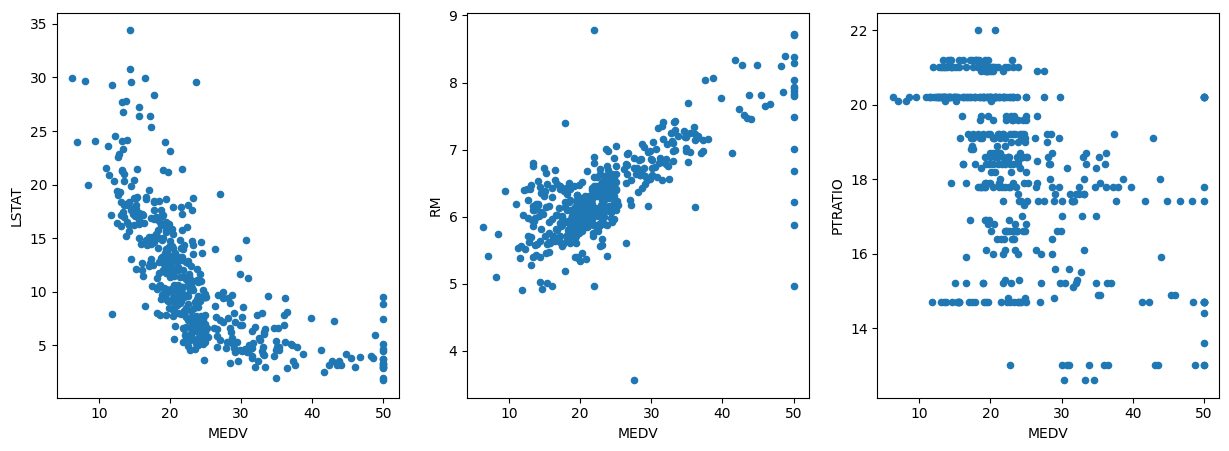

In [17]:
 fig, ax = plt.subplots(1, 3, figsize=(15, 5))

boston_housing_pandas_dataframe.plot.scatter(x='MEDV', y='LSTAT', ax=ax[0])
boston_housing_pandas_dataframe.plot.scatter(x='MEDV', y='RM', ax=ax[1])
boston_housing_pandas_dataframe.plot.scatter(x='MEDV', y='PTRATIO', ax=ax[2])

plt.show()

The correlation coefficient ranges from -1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median value (MED) tends to go up when the number of rooms (RM) goes up. When the coefficient is close to -1, it means that there is a strong negative correlation; the median value (MED) tends to go down when the percentage of the lower status of the population (LSTAT) goes up.

### Section 3

Create a regression model using a polynomial function of degree two on the three selected variables. Use 70% of the data for training;

y=a*x^2+ b*x+ c

24 = a * 43.230 + b * 6.575 + c

In [18]:
boston_housing = boston_housing.withColumn("LSTAT2", col("LSTAT") * col("LSTAT"))
boston_housing = boston_housing.withColumn ("RM2", col("RM") * col("RM"))
#boston_housing = boston_housing.withColumn ("RM2", col("RM") * col("RM"))

rmAssembler = VectorAssembler(inputCols = ['RM2', 'RM'] , outputCol='rm_features')
lstatAssembler = VectorAssembler (inputCols = ['LSTAT2', 'LSTAT'] , outputCol= 'lstat_features')

df_rm = rmAssembler.transform(boston_housing).select (['MEDV', 'rm_features'])
df_lstat = lstatAssembler.transform(boston_housing).select(['MEDV', 'lstat_features'])

df_rm.show()
df_lstat.show()

df_training_lstat, df_test_lstat = df_lstat.randomSplit([0.7, 0.3])
df_training_rm, df_test_rm = df_rm.randomSplit([0.7, 0.3])

+----+--------------------+
|MEDV|         rm_features|
+----+--------------------+
|24.0|   [43.230625,6.575]|
|21.6|   [41.229241,6.421]|
|34.7|[51.6242249999999...|
|33.4|[48.9720040000000...|
|36.2|[51.0796090000000...|
|28.7|[41.3448999999999...|
|22.9|   [36.144144,6.012]|
|27.1|   [38.093584,6.172]|
|16.5|[31.7081610000000...|
|18.9|   [36.048016,6.004]|
|15.0|   [40.666129,6.377]|
|18.9|[36.1080810000000...|
|21.7|   [34.680321,5.889]|
|20.4|   [35.390601,5.949]|
|18.2|   [37.161216,6.096]|
|19.9|[34.0355559999999...|
|23.1|   [35.224225,5.935]|
|17.5|[35.8801000000000...|
|20.2|[29.7679360000000...|
|18.2|   [32.798529,5.727]|
+----+--------------------+
only showing top 20 rows

+----+--------------------+
|MEDV|      lstat_features|
+----+--------------------+
|24.0|[24.8004000000000...|
|21.6|[83.5396000000000...|
|34.7|[16.2409000000000...|
|33.4|       [8.6436,2.94]|
|36.2|      [28.4089,5.33]|
|28.7|[27.1440999999999...|
|22.9|    [154.5049,12.43]|
|27.1|[366.72249999999

### Create a regression model

**maxiter** : It is the maximum number of iterations to perform before giving up.

#### Create a regression model
maxIter : It is the maximum number of iterations to perform before giving up.

In [19]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

pr = LinearRegression(featuresCol="lstat_features", labelCol="MEDV", maxIter=30)
prModel = pr.fit(df_training_lstat)

print("Coefficients: " + str (prModel.coefficients))
print("Intercept:" + str (prModel.intercept)) # Describe Intercept

print ("R2:", prModel.summary.r2)

Coefficients: [0.06404201000900049,-2.7948785905603297]
Intercept:44.82321972198816
R2: 0.6406552245678143


$$ y=a \times x^2+ b \times x+ c $$



$$MEDV = 0.055 \times (LSTAT)^2 - 2.55 \times (LSTAT) + 43.44$$

In [20]:
import numpy as np
from matplotlib import pyplot as plt

x = np.linspace(0, 50, 100)
# From 0 to 50, create 100 numbers with equal distance


In [21]:
x

array([ 0.        ,  0.50505051,  1.01010101,  1.51515152,  2.02020202,
        2.52525253,  3.03030303,  3.53535354,  4.04040404,  4.54545455,
        5.05050505,  5.55555556,  6.06060606,  6.56565657,  7.07070707,
        7.57575758,  8.08080808,  8.58585859,  9.09090909,  9.5959596 ,
       10.1010101 , 10.60606061, 11.11111111, 11.61616162, 12.12121212,
       12.62626263, 13.13131313, 13.63636364, 14.14141414, 14.64646465,
       15.15151515, 15.65656566, 16.16161616, 16.66666667, 17.17171717,
       17.67676768, 18.18181818, 18.68686869, 19.19191919, 19.6969697 ,
       20.2020202 , 20.70707071, 21.21212121, 21.71717172, 22.22222222,
       22.72727273, 23.23232323, 23.73737374, 24.24242424, 24.74747475,
       25.25252525, 25.75757576, 26.26262626, 26.76767677, 27.27272727,
       27.77777778, 28.28282828, 28.78787879, 29.29292929, 29.7979798 ,
       30.3030303 , 30.80808081, 31.31313131, 31.81818182, 32.32323232,
       32.82828283, 33.33333333, 33.83838384, 34.34343434, 34.84

In [22]:
fx = []
for i in range(len(x)):
    fx.append(prModel.coefficients[0]*x[i]*x[i] + prModel.coefficients[1]*x[i] + prModel.intercept)

In [23]:
fx

[44.82321972198816,
 43.42800045882612,
 42.065452356774685,
 40.73557541583385,
 39.438369636003614,
 38.173835017283984,
 36.941971559674954,
 35.74277926317652,
 34.57625812778869,
 33.442408153511465,
 32.34122934034484,
 31.27272168828881,
 30.23688519734339,
 29.233719867508565,
 28.26322569878434,
 27.325402691170723,
 26.4202508446677,
 25.547770159275284,
 24.707960634993466,
 23.90082227182225,
 23.126355069761637,
 22.384559028811623,
 21.675434148972208,
 20.9989804302434,
 20.355197872625194,
 19.744086476117584,
 19.165646240720577,
 18.619877166434165,
 18.10677925325836,
 17.62635250119316,
 17.178596910238557,
 16.763512480394553,
 16.38109921166115,
 16.031357104038356,
 15.71428615752616,
 15.42988637212456,
 15.178157747833566,
 14.959100284653168,
 14.772713982583383,
 14.618998841624187,
 14.4979548617756,
 14.409582043037606,
 14.353880385410221,
 14.330849888893436,
 14.340490553487246,
 14.382802379191666,
 14.457785366006682,
 14.565439513932304,
 14.705764822

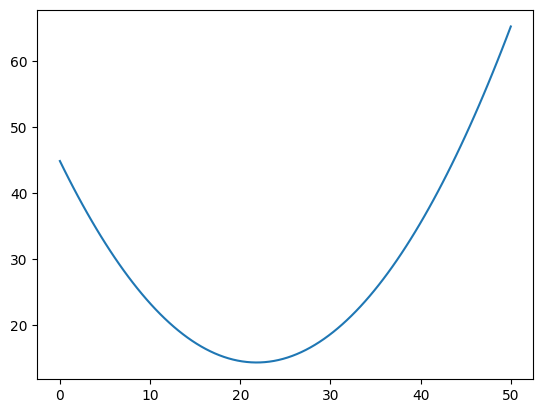

In [24]:
plt.plot(x, fx)
plt.show()

*R squared at 0.65 indicates that in our model, approximate 65% of the variability in "MEDV" can be explained using the model and the considered independent variable(s).*

#### Compute the R-Squared value of the model using the remaining 30% of the test data

In [26]:
pr_predictions = prModel.transform(df_test_lstat)
pr_predictions.show()

pr_predictions.select("prediction", "MEDV", "lstat_features")

pr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="MEDV", metricName="r2")

print("R2 on test data:", pr_evaluator.evaluate(pr_predictions))

+----+--------------------+------------------+
|MEDV|      lstat_features|        prediction|
+----+--------------------+------------------+
| 7.0|    [574.5609,23.97]|14.626014814837383|
| 8.1|    [880.9024,29.68]| 18.28598347191013|
| 9.5|[579.846399999999...| 14.65707221377832|
|11.7|    [294.4656,17.16]|15.721272010479236|
|11.9|      [62.0944,7.88]|26.776226614675643|
|12.3|    [603.1936,24.56]|14.810732106391502|
|13.0|[372.876099999999...|14.733849066585261|
|13.1|[260.499600000000...|16.396797260885062|
|13.1|    [293.0944,17.12]|15.745252749977308|
|13.3|[451.137599999999...|14.351757153123216|
|13.4|    [542.4241,23.29]| 14.46842698916116|
|13.5|[286.963600000000...|15.855702141314985|
|13.9|[272.580100000000...|16.136351684291473|
|14.0|    [583.7056,24.16]|14.680632851560233|
|14.1|[328.696899999999...|15.202481034856817|
|14.2|[246.489999999999...|16.729340897309516|
|14.3|    [263.0884,16.22]|16.338998929151536|
|14.4|    [949.2561,30.81]| 19.50527900412917|
|14.4|[1184.0

Compare R2?

**Sure enough, we achieved worse R squared on the test set.**